<a href="https://colab.research.google.com/github/Hrishkesh/Invoice-/blob/master/Data_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [630]:
!git clone https://github.com/Hrishkesh/Invoice-.git

fatal: destination path 'Invoice-' already exists and is not an empty directory.


In [ ]:
!ls Invoice-/

Data_visualization.ipynb  network.py		preprocessing_ter.py
example.png		  preprocessing_bis.py	README.md
Invoice_new.ipynb	  preprocessing.py


In [ ]:
import os
from getpass import getpass
user = getpass('GitHub user')
password = getpass('GitHub password')
os.environ['GITHUB_AUTH'] = user + ':' + password
os.environ['GITHUB_USER'] = user
os.environ['GITHUB_PASSWORD'] = user

GitHub user··········
GitHub password··········


In [ ]:
!git config --global user.email "hrishkesh.pattepu@gmail.com"
!git config --global user.name "Hrishkesh"

In [ ]:
!cd Invoice- && git remote set-url origin https://$GITHUB_AUTH@github.com/$GITHUB_USER/Invoice-.git

In [ ]:
!cd Invoice- && git pull

Already up to date.


In [ ]:
!cd Invoice- && git add .

In [ ]:
!cd Invoice- && git commit -m "training"

On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean


In [ ]:
!cd Invoice- && git push

Everything up-to-date


In [ ]:
!pip install colab_ssh --upgrade

In [ ]:
from colab_ssh import launch_ssh, init_git
from getpass import getpass
ngrokToken = '1cfbiKCtHgohcxmNMIXe34CpbET_7GibpvfZdp55n7ordbjoT'
#password = getpass('Password of your choice')
password = 'root'
launch_ssh(ngrokToken,password)

Successfully running 2.tcp.ngrok.io:11025
[Optional] You can also connect with VSCode SSH Remote extension using this configuration:

	Host google_colab_ssh
		HostName 2.tcp.ngrok.io
		User root
		Port 11025
	  


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!apt install tesseract-ocr -q
!pip install pytesseract

Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 59 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 3s (1,777 kB/s)
Selecting previously unselected package tes

In [925]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.patches as patches
import pytesseract as te
import os
import re
import json
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [926]:
!ls /content/drive

'My Drive'


In [ ]:
!unzip /content/drive/My\ Drive/invoice_eng/input/Data_Folder.zip -d /content/drive/My\ Drive/

In [927]:
!ls /content/drive/My\ Drive

dir_boxes  dir_classes	dir_img  invoice_eng


In [976]:
## Hyperparameters
dir_img = "/content/drive/My Drive/dir_img"
dir_boxes = "/content/drive/My Drive/dir_boxes"
dir_classes = "/content/drive/My Drive/dir_classes"
outdir_np_chargrid = "/content/data/np_chargrids/"
outdir_png_chargrid = "/content/data/img_chargrids/"
outdir_np_gt = "/content/data/np_gt/"
outdir_png_gt = "/content/data/img_gt/"
outdir_pd_bbox = "/content/data/pd_bbox/"
tesseract_conf_threshold = 10
cosine_similarity_threshold = 0.4
list_classes = ["company", "date", "address", "total"]
nb_classes = len(list_classes)

In [977]:
list_dir = [outdir_np_chargrid, outdir_png_chargrid, outdir_np_gt, outdir_png_gt, outdir_pd_bbox]
for dir in list_dir:
  if not os.path.exists(dir):
      os.makedirs(dir)

In [978]:
list_filenames = [f for f in os.listdir(dir_img) if os.path.isfile(os.path.join(dir_img, f)) and os.path.isfile(os.path.join(dir_boxes, f).replace("jpg", "txt")) and os.path.isfile(os.path.join(dir_classes, f).replace("jpg", "txt"))]
len(list_filenames)

618

In [979]:
list_filenames.sort()

In [980]:
def extract_tesseract_information(filename):
    img = plt.imread(os.path.join(dir_img, filename), format='jpeg')
    print(filename, img.shape)
    
    dt = te.image_to_data(img, config="", output_type=te.Output.DATAFRAME, pandas_config=None)
    dt = dt[dt['conf']>tesseract_conf_threshold]
    dt["text"] = dt["text"].astype('str')
    
    return dt, img.shape

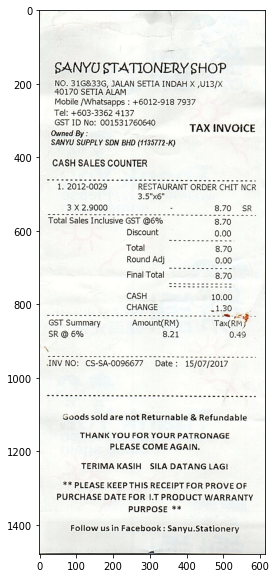

In [981]:
import random
index = random.randint(0,len(list_filenames))
filename = list_filenames[index]
# filename = 'X51006393376.jpg'
img = np.array(Image.open('/content/drive/My Drive/dir_img/' + filename), dtype=np.uint8)
#img = mpimg.imread('/content/drive/My Drive/dir_img/' + filename)
fig = plt.figure(figsize=(10,10))
plt.imshow(img)

# Extract tesseract dataframe (Bounding box for each word)

In [982]:
dt, img_shape = extract_tesseract_information(filename)
print(img_shape)

X51007339151.jpg (1479, 615, 3)
(1479, 615, 3)


In [983]:
dt

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
4,5,1,1,1,1,1,43,141,123,32,89,SANYU
5,5,1,1,1,1,2,174,142,232,33,96,STATIONERY
6,5,1,1,1,1,3,411,143,96,33,96,SHOP
10,5,1,2,1,1,1,44,191,34,16,92,NO.
11,5,1,2,1,1,2,88,191,99,21,85,"31G&33G,"
...,...,...,...,...,...,...,...,...,...,...,...,...
196,5,1,17,1,3,2,361,1347,23,12,90,**
200,5,1,18,1,1,1,87,1400,73,16,95,Follow
201,5,1,18,1,1,2,168,1400,47,17,89,usin
202,5,1,18,1,1,3,224,1400,117,17,92,Facebook:


# Bounding box to each letter from output of tesseract : chargrid_pd

In [984]:
def get_chargrid(dt):
    chargrid_pd = pd.DataFrame(columns = ['left', 'top', 'width', 'height', 'ord', 'conf'])

    for index, row in dt.iterrows():
        for i in range(0, len(row["text"])):
            row['width'] = (row['width']+len(row["text"])-1)//len(row["text"])*len(row["text"]) # Split character by character
        
            chargrid_pd = chargrid_pd.append({
            'left':row['left']+row['width']*i//len(row["text"]),
            'top':row['top'],
            'width':row['width']//len(row["text"]),
            'height':row['height'],
            'ord':ord(row["text"][i]),
            'conf':row["conf"]
            }, ignore_index = True)

    chargrid_pd = chargrid_pd[chargrid_pd['ord']>=33]
    chargrid_pd = chargrid_pd[chargrid_pd['ord']<=126]
    chargrid_pd['ord'] -= 32
    
    return chargrid_pd

In [985]:
chargrid_pd = get_chargrid(dt)

In [986]:
chargrid_pd

,left,top,width,height,ord,conf
0,43,141,25,32,51,89
1,68,141,25,32,33,89
2,93,141,25,32,46,89
3,118,141,25,32,57,89
4,143,141,25,32,53,89
...,...,...,...,...,...,...
594,492,1401,13,22,79,86
595,505,1401,13,22,78,86
596,518,1401,13,22,69,86
597,531,1401,13,22,82,86


# Draw bounding boxes on group of words using dir_boxes ground truth txt files

In [987]:
def add_row_gt_pd(row, c, gt_pd):
    return gt_pd.append({
            'left':row['top_left_x'],
            'top':row['top_left_y'],
            'right':row['bot_right_x'],
            'bot':row['bot_right_y'],
            'class':c
            }, ignore_index = True)

In [988]:
def extract_class_bounding_boxes(filename):
    gt_pd = pd.DataFrame(columns = ['left', 'top', 'right', 'bot', 'class'])
    
    ## Import ground truth files
    pd_boxes = pd.DataFrame(columns=['top_left_x', 'top_left_y', 'top_right_x', 'top_right_y', 'bot_left_x', 'bot_left_y', 'bot_right_x', 'bot_right_y', 'text'])
    dic_class = dict()
    
    with open(os.path.join(dir_boxes, filename).replace("jpg", "txt")) as f:
        reader = f.read().splitlines()
        pd_boxes = pd.DataFrame([x.split(",", 8) for x in reader], columns=['top_left_x', 'top_left_y', 'top_right_x', 'top_right_y', 'bot_right_x', 'bot_right_y', 'bot_left_x', 'bot_left_y', 'text'])
    
        pd_boxes["top_left_x"] = pd_boxes["top_left_x"].astype('int')
        pd_boxes["top_left_y"] = pd_boxes["top_left_y"].astype('int')
        pd_boxes["top_right_x"] = pd_boxes["top_right_x"].astype('int')
        pd_boxes["top_right_y"] = pd_boxes["top_right_y"].astype('int')
        pd_boxes["bot_left_x"] = pd_boxes["bot_left_x"].astype('int')
        pd_boxes["bot_left_y"] = pd_boxes["bot_left_y"].astype('int')
        pd_boxes["bot_right_x"] = pd_boxes["bot_right_x"].astype('int')
        pd_boxes["bot_right_y"] = pd_boxes["bot_right_y"].astype('int')
        pd_boxes["text"] = pd_boxes["text"].str.upper()

        fig,ax = plt.subplots(1, figsize=(10,10))
        ax.imshow(img)
        for i in range(len(pd_boxes)):
          rect = patches.Rectangle((pd_boxes['bot_left_x'][i],pd_boxes['bot_left_y'][i]),
                             (pd_boxes['top_right_x'][i]-pd_boxes['top_left_x'][i]),
                             (pd_boxes['top_left_y'][i]-pd_boxes['bot_left_y'][i]),
                             linewidth=1,edgecolor='r',facecolor='none')
          ax.add_patch(rect)
        plt.show()
  
        
    
    with open(os.path.join(dir_classes, filename).replace("jpg", "txt")) as f:
        dic_class = json.load(f)
    for i in range(nb_classes):
        if list_classes[i] not in dic_class.keys():
            dic_class[list_classes[i]] = "UNKNOWN"
        dic_class[list_classes[i]] = dic_class[list_classes[i]].upper()
    
    ## Detect classes in the bounding box file
    vectorized_text = CountVectorizer().fit_transform([dic_class[list_classes[i]] for i in range(nb_classes)]+pd_boxes["text"].tolist())
    
    for index, row in pd_boxes.iterrows():
        #Classes of type string
        if cosine_similarity(vectorized_text[0].reshape(1, -1), vectorized_text[index+nb_classes].reshape(1, -1))[0][0] > cosine_similarity_threshold:
            gt_pd = add_row_gt_pd(row, 3, gt_pd)
        
        if cosine_similarity(vectorized_text[2].reshape(1, -1), vectorized_text[index+nb_classes].reshape(1, -1))[0][0] > cosine_similarity_threshold:
            gt_pd = add_row_gt_pd(row, 2, gt_pd)
        
        #Classes of type date
        tab_date = re.findall(r'((?i)(?:[12][0-9]|3[01]|0*[1-9])(?P<sep>[- \/.\\])(?P=sep)*(?:1[012]|0*[1-9]|jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)(?P=sep)+(?:19|20)\d\d|(?:[12][0-9]|3[01]|0*[1-9])(?P<sep2>[- \/.\\])(?P=sep2)*(?:1[012]|0*[1-9]|jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)(?P=sep2)+\d\d|(?:1[012]|0*[1-9]|jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)(?P<sep3>[- \/.\\])(?P=sep3)*(?:[12][0-9]|3[01]|0*[1-9])(?P=sep3)+(?:19|20)\d\d|(?:1[012]|0*[1-9]|jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)(?P<sep4>[- \/.\\])(?P=sep4)*(?:[12][0-9]|3[01]|0*[1-9])(?P=sep4)+\d\d|(?:19|20)\d\d(?P<sep5>[- \/.\\])(?P=sep5)*(?:1[012]|0*[1-9]|jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)(?P=sep5)+(?:[12][0-9]|3[01]|0*[1-9])|\d\d(?P<sep6>[- \/.\\])(?P=sep6)*(?:1[012]|0*[1-9]|jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)(?P=sep6)+(?:[12][0-9]|3[01]|0*[1-9])|(?:[12][0-9]|3[01]|0*[1-9])(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)(?:19|20)\d\d|(?:[12][0-9]|3[01]|0*[1-9])(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)\d\d|(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)(?:[12][0-9]|3[01]|0*[1-9])(?:19|20)\d\d|(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)(?:[12][0-9]|3[01]|0*[1-9])\d\d|(?:19|20)\d\d(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)(?:[12][0-9]|3[01]|0*[1-9])|\d\d(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)(?:[12][0-9]|3[01]|0*[1-9])|(?:[12][0-9]|3[01]|0[1-9])(?:1[012]|0[1-9])(?:19|20)\d\d|(?:1[012]|0[1-9])(?:[12][0-9]|3[01]|0[1-9])(?:19|20)\d\d|(?:19|20)\d\d(?:1[012]|0[1-9])(?:[12][0-9]|3[01]|0[1-9])|(?:1[012]|0[1-9])(?:[12][0-9]|3[01]|0[1-9])\d\d|(?:[12][0-9]|3[01]|0[1-9])(?:1[012]|0[1-9])\d\d|\d\d(?:1[012]|0[1-9])(?:[12][0-9]|3[01]|0[1-9]))', row["text"])
        for dat in tab_date:
            if dat[0] == dic_class["date"]:
                gt_pd = add_row_gt_pd(row, 4, gt_pd)
        
        #Classes of type float
        tab_floats = re.findall(r'([-+]?[0-9]*\.?[0-9]+)', row["text"])
        total_float = re.search(r'([-+]?[0-9]*\.?[0-9]+)', dic_class["total"])
        if total_float:
            for flo in tab_floats:
                if float(total_float.group(0)) == float(flo):
                    gt_pd = add_row_gt_pd(row, 1, gt_pd)
    
    return gt_pd

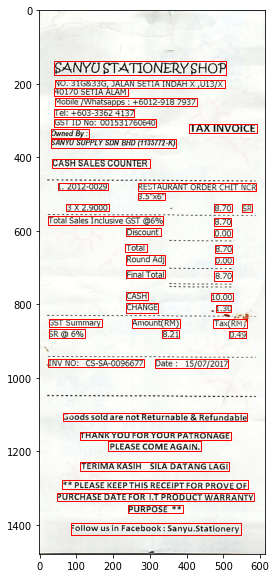

In [989]:
gt_pd = extract_class_bounding_boxes(filename)

In [990]:
pd_boxes.head()

,top_left_x,top_left_y,top_right_x,top_right_y,bot_right_x,bot_right_y,bot_left_x,bot_left_y,text
0,151,93,574,93,574,142,151,142,POPULAR BOOK
1,114,150,644,150,644,208,114,208,CO. (M) SDN BHD
2,202,214,518,214,518,245,202,245,(CO. NO. 113825-W)
3,131,253,590,253,590,285,131,285,(GST REG NO. 001492992000)
4,54,291,663,291,663,323,54,323,"NO 8, JALAN 7/118B, DESA TUN RAZAK"


In [991]:
gt_pd

,left,top,right,bot,class
0,40,139,508,176,3
1,42,189,503,210,2
2,40,212,240,233,2
3,475,528,523,549,1
4,474,566,522,586,1
5,477,639,524,661,1
6,475,708,524,735,1
7,313,949,512,972,4
8,84,1396,549,1426,3


# Draw bounding boxes based on classes

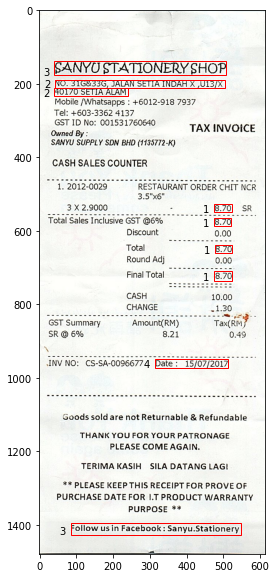

In [992]:
fig,ax = plt.subplots(1,figsize=(10,10))
ax.imshow(img)
for i in range(len(gt_pd)):
  rect1 = patches.Rectangle((gt_pd['left'][i],gt_pd['top'][i]),
                            (gt_pd['right'][i]-gt_pd['left'][i]),
                            (gt_pd['bot'][i]-gt_pd['top'][i]),
                            linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect1)
  ax.text(gt_pd['left'][i]-30,gt_pd['bot'][i],gt_pd['class'][i])  
plt.show()

In [993]:
chargrid_pd.head()

,left,top,width,height,ord,conf
0,43,141,25,32,51,89
1,68,141,25,32,33,89
2,93,141,25,32,46,89
3,118,141,25,32,57,89
4,143,141,25,32,53,89


In [994]:
gt_pd.head()

,left,top,right,bot,class
0,40,139,508,176,3
1,42,189,503,210,2
2,40,212,240,233,2
3,475,528,523,549,1
4,474,566,522,586,1


In [995]:
img_shape

(1479, 615, 3)

In [996]:
np.array([0]*img_shape[0]*img_shape[1]).reshape((img_shape[0], img_shape[1])).shape

(1479, 615)

# Replace each pixel in input image by ASCII value --> chargrid_np
# Replace each pixel in output image by class number --> gt_np

In [997]:
def get_reduced_output(chargrid_pd, gt_pd, img_shape):

    # Add plots
    fig, ax = plt.subplots(1, 4, figsize=(15, 15))
    ax[0].imshow(img)
    ax[1].imshow(img)
    for i in range(len(gt_pd)):
      rect1 = patches.Rectangle((gt_pd['left'][i],gt_pd['top'][i]),
                          (gt_pd['right'][i]-gt_pd['left'][i]),
                          (gt_pd['bot'][i]-gt_pd['top'][i]),
                          linewidth=1,edgecolor='r',facecolor='none')
      ax[1].add_patch(rect1)
      ax[1].text(gt_pd['left'][i]-30,gt_pd['bot'][i],gt_pd['class'][i])  

    chargrid_np = np.array([0]*img_shape[0]*img_shape[1]).reshape((img_shape[0], img_shape[1]))
    
    chargrid_pd.sort_values(by="conf", ascending=True, inplace=True) #Sort by confidence
    chargrid_pd.reset_index(drop=True, inplace=True)
    
    for index, row in chargrid_pd.iterrows():
        chargrid_np[row['top']:row['top']+row['height'], row['left']:row['left']+row['width']] = row['ord']
    
    gt_np = np.array([0]*img_shape[0]*img_shape[1]).reshape((img_shape[0], img_shape[1]))
    
    gt_pd.sort_values(by="class", ascending=True, inplace=True) #Sort by confidence
    gt_pd.reset_index(drop=True, inplace=True)
    
    for index, row in gt_pd.iterrows():
        gt_np[row['top']:row['bot'], row['left']:row['right']] = row['class']
 
    ax[2].imshow(chargrid_np)
    ax[3].imshow(gt_np)
    
    ## Remove empty rows and columns
    tab_cumsum_todelete_x = np.cumsum(np.all(chargrid_np == 0, axis=0))
    gt_pd['left'] -= tab_cumsum_todelete_x[gt_pd['left'].tolist()]
    gt_pd['right'] -= tab_cumsum_todelete_x[gt_pd['right'].tolist()]
    
    tab_cumsum_todelete_y = np.cumsum(np.all(chargrid_np == 0, axis=1))
    gt_pd['top'] -= tab_cumsum_todelete_y[gt_pd['top'].tolist()]
    gt_pd['bot'] -= tab_cumsum_todelete_y[gt_pd['bot'].tolist()]
    
    gt_np = gt_np[:,~np.all(chargrid_np == 0, axis=0)]
    gt_np = gt_np[~np.all(chargrid_np == 0, axis=1),:]

    img_cropped = img[:,~np.all(chargrid_np == 0, axis=0)]
    img_cropped = img_cropped[~np.all(chargrid_np == 0, axis=1), :]
    print(img_shape)
    print(img_cropped.shape)
    
    chargrid_np = chargrid_np[:,~np.all(chargrid_np == 0, axis=0)]
    chargrid_np = chargrid_np[~np.all(chargrid_np == 0, axis=1),:]


    fig, ax = plt.subplots(1, 4, figsize=(15, 15))

    ax[0].imshow(img_cropped)

    ax[1].imshow(chargrid_np)
    ax[2].imshow(gt_np)

    ax[3].imshow(img_cropped, cmap='gray', alpha=0.5)
    ax[3].imshow(gt_np, cmap='jet', alpha=0.5)
    
    return chargrid_np, gt_np, gt_pd, img_cropped

(1479, 615, 3)
(616, 567, 3)


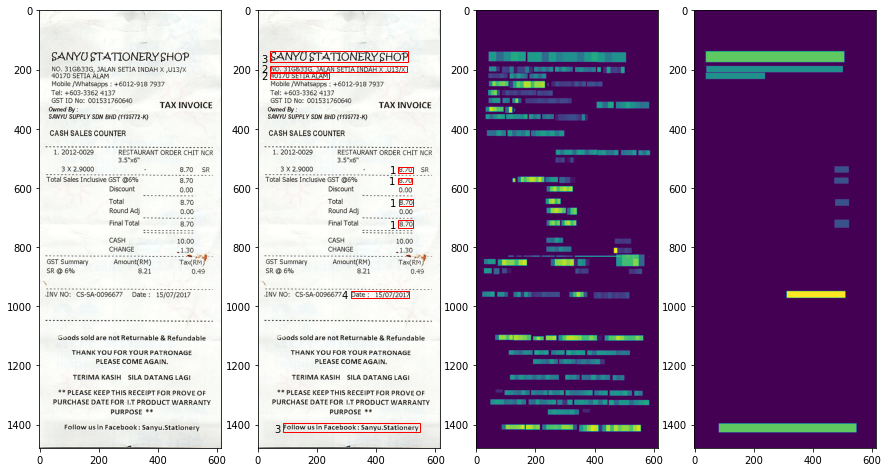

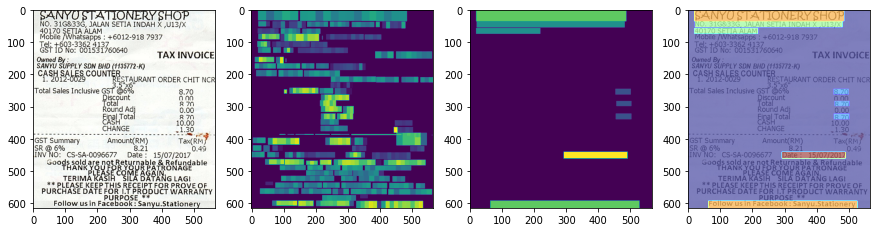

In [998]:
chargrid_np, gt_np, gt_pd, img_cropped = get_reduced_output(chargrid_pd, gt_pd, img_shape)

In [999]:
def get_reduce(img, axis):
    reduce_f = 1
    
    trust = 1.0
    reduce = 1
    while reduce <= img.shape[axis]/2:
        reduce += 1
        if img.shape[axis]%reduce == 0:
            if axis == 0:
                img_reshaped = img.reshape(img.shape[0]//reduce, -1, img.shape[1])
                img2 = np.repeat(np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=img_reshaped), reduce, axis=axis)
            else:
                img_reshaped = img.reshape(img.shape[0], img.shape[1]//reduce, -1)
                img2 = np.repeat(np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=2, arr=img_reshaped), reduce, axis=axis)
                
            trust = np.sum(img == img2)/(np.shape(img)[0]*np.shape(img)[1])
            if trust > equal_threshold:
                reduce_f = reduce

    return reduce_f

In [1000]:
def get_max_reduce(img, axis):
    reduce_f = get_reduce(img, axis)
    padding_left = 0
    padding_right = 0

    for i in range(0, max_padding):
        img = np.insert(img, 0, 0, axis=axis)
        reduce_f_ = get_reduce(img, axis)
        if reduce_f_ > reduce_f:
            reduce_f = reduce_f_
            padding_left = i+1
            padding_right = i
            
        img = np.insert(img, 0, img.shape[axis], axis=axis)
        reduce_f_ = get_reduce(img, axis)
        if reduce_f_ > reduce_f:
            reduce_f = reduce_f_
            padding_left = i+1
            padding_right = i+1
    
    return reduce_f, padding_left, padding_right

In [1001]:
def get_img_reduced(img, reduce_x, reduce_y, padding_left, padding_right, padding_top, padding_bot):
    img2 = img
    for i in range(0, padding_top):
        img2 = np.insert(img2, 0, 0, axis=0)
    for i in range(0, padding_bot):
        img2 = np.insert(img2, 0, img2.shape[0], axis=0)
    for i in range(0, padding_left):
        img2 = np.insert(img2, 0, 0, axis=1)
    for i in range(0, padding_right):
        img2 = np.insert(img2, 0, img2.shape[1], axis=1)
    
    img2_reshaped = img2.reshape(img2.shape[0]//reduce_y, -1, img2.shape[1])
    img2 = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=img2_reshaped)
    
    img2_reshaped = img2.reshape(img2.shape[0], img2.shape[1]//reduce_x, -1)
    img2 = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=2, arr=img2_reshaped)
    
    return img2

In [1002]:
reduce_y, padding_top, padding_bot = get_max_reduce(chargrid_np, 0)

In [1003]:
reduce_x, padding_left, padding_right = get_max_reduce(chargrid_np, 1)

In [1004]:
chargrid_np2 = get_img_reduced(chargrid_np, reduce_x, reduce_y, padding_left, padding_right, padding_top, padding_bot)
gt_np2 = get_img_reduced(gt_np, reduce_x, reduce_y, padding_left, padding_right, padding_top, padding_bot)

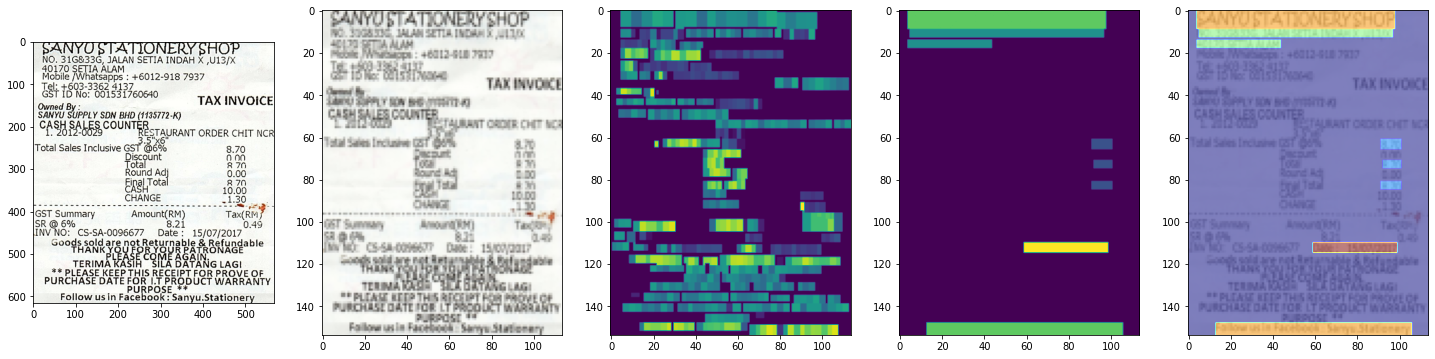

In [1005]:
from skimage.transform import resize
img_cropped_resized = resize(img_cropped, (chargrid_np2.shape[0], chargrid_np2.shape[1],img_cropped.shape[2]))
fig, ax = plt.subplots(1, 5, figsize=(25, 25))
ax[0].imshow(img_cropped)
ax[1].imshow(img_cropped_resized)
ax[2].imshow(chargrid_np2)
ax[3].imshow(gt_np2)
ax[4].imshow(img_cropped_resized, cmap='gray', alpha=0.5)
ax[4].imshow(gt_np2, cmap='jet', alpha=0.5)

In [1006]:
def reduce_pd_bbox(pd_bbox, padding_left, padding_top, reduce_x, reduce_y):
    pd_bbox['left'] += padding_left
    pd_bbox['right'] += padding_left
    pd_bbox['top'] += padding_top
    pd_bbox['bot'] += padding_top
    
    pd_bbox['left'] = pd_bbox['left'].astype(float)
    pd_bbox['right'] = pd_bbox['right'].astype(float)
    pd_bbox['top'] = pd_bbox['top'].astype(float)
    pd_bbox['bot'] = pd_bbox['bot'].astype(float)

    pd_bbox['left'] = round(pd_bbox['left']/reduce_x)
    pd_bbox['right'] = round(pd_bbox['right']/reduce_x)
    pd_bbox['top'] = round(pd_bbox['top']/reduce_y)
    pd_bbox['bot'] = round(pd_bbox['bot']/reduce_y)
    
    pd_bbox['left'] = pd_bbox['left'].astype(int)
    pd_bbox['right'] = pd_bbox['right'].astype(int)
    pd_bbox['top'] = pd_bbox['top'].astype(int)
    pd_bbox['bot'] = pd_bbox['bot'].astype(int)
    
    return pd_bbox

In [1007]:
gt_pd = reduce_pd_bbox(gt_pd, padding_left, padding_top, reduce_x, reduce_y)

In [1008]:
!wget https://www.dropbox.com/s/ws0a5c7eqcbwdc3/preprocessing_ter.zip

--2020-06-27 13:55:33--  https://www.dropbox.com/s/ws0a5c7eqcbwdc3/preprocessing_ter.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ws0a5c7eqcbwdc3/preprocessing_ter.zip [following]
--2020-06-27 13:55:33--  https://www.dropbox.com/s/raw/ws0a5c7eqcbwdc3/preprocessing_ter.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9fca0d57140339eec2e75a5c89.dl.dropboxusercontent.com/cd/0/inline/A6fK5HxOJD-HYX397Bcm2UsWc_FcWjBWuanSrgf1doAZE0lC6VOllQr9RlJs-fyw_p_cKUm02jWfRbTF5lpvOcC3GgBe7FJdB2Z9JPH-1qewDLSQHN7Gto6nPyZ6ZTK5tOw/file# [following]
--2020-06-27 13:55:33--  https://uc9fca0d57140339eec2e75a5c89.dl.dropboxusercontent.com/cd/0/inline/A6fK5HxOJD-HYX397Bcm2UsWc_FcWjBWuanSrgf1doAZE0lC6VOllQr9RlJs-fyw_p_cKUm02jWfRbTF5lpv

In [1009]:
#!unzip preprocessing_ter.zip -d /content/data/

In [1010]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from skimage.transform import resize

In [1011]:
dir_np_chargrid_reduced = "/content/data/outdir_np_chargrid_reduced"
dir_np_gt_reduced = "/content/data/outdir_np_gt_reduced"
dir_pd_bbox_reduced = "/content/data/outdir_pd_bbox_reduced"
outdir_np_chargrid_1h = "/content/data/outdir_np_chargrid_1h"
outdir_np_gt_1h = "/content/data/outdir_np_gt_1h"
outdir_np_bbox_anchor_mask = "/content/data/outdir_np_bbox_anchor_mask"
outdir_np_bbox_anchor_coord = "/content/data/outdir_np_bbox_anchor_coord"
target_height = 256
target_width = 128
target_digit = 61
target_class = 5
nb_anchors = 4 # one per foreground class
nb_digit_threshold = 10000

In [1012]:
list_filenames = [f for f in os.listdir(dir_np_chargrid_reduced) if os.path.isfile(os.path.join(dir_np_chargrid_reduced, f))]

In [1013]:
list_filenames.sort()

In [1014]:
## Load inputs
tab_img = []
tab_gt = []
for i in range(0, len(list_filenames)):
    tab_img.append(np.load(os.path.join(dir_np_chargrid_reduced, list_filenames[i])))
    tab_gt.append(np.load(os.path.join(dir_np_gt_reduced, list_filenames[i])))

In [1015]:
print("tab_img shape=", np.shape(tab_img))
print("tab_gt shape=", np.shape(tab_gt))

tab_img shape= (618,)
tab_gt shape= (618,)


In [1016]:
def print_stats_img(tab_img):
    fig, ax = plt.subplots(1, 4, figsize=(10, 10))
    fig.suptitle('Minumum width and maximum width images', fontsize=12)
    tab_width = [np.shape(tab_img[i])[0] for i in range(0, len(tab_img))]
    print("min width=", np.min(tab_width), list_filenames[np.argmin(tab_width)])
    ax[0].imshow(np.array(Image.open('/content/drive/My Drive/dir_img/' + list_filenames[np.argmin(tab_width)].replace('npy', 'jpg')), dtype=np.uint8))
    ax[1].imshow(np.load(dir_np_chargrid_reduced + '/' + list_filenames[np.argmin(tab_width)]))
    print("max width=", np.max(tab_width), list_filenames[np.argmax(tab_width)])
    ax[2].imshow(np.array(Image.open('/content/drive/My Drive/dir_img/' + list_filenames[np.argmax(tab_width)].replace('npy', 'jpg')), dtype=np.uint8))
    ax[3].imshow(np.load(dir_np_chargrid_reduced + '/' + list_filenames[np.argmax(tab_width)]))
    print("ave width=", np.average(tab_width))
    print("std width=", np.std(tab_width))

    tab_height = [np.shape(tab_img[i])[1] for i in range(0, len(tab_img))]
    fig, ax = plt.subplots(1, 4, figsize=(10, 10))
    fig.suptitle('Minumum height and maximum height images', fontsize=12)
    ax[0].imshow(np.array(Image.open('/content/drive/My Drive/dir_img/' + list_filenames[np.argmin(tab_height)].replace('npy', 'jpg')), dtype=np.uint8))
    ax[1].imshow(np.load(dir_np_chargrid_reduced + '/' + list_filenames[np.argmin(tab_height)]))
    print("min height=", np.min(tab_height))
    print("max height=", np.max(tab_height), list_filenames[np.argmax(tab_height)])
    ax[2].imshow(np.array(Image.open('/content/drive/My Drive/dir_img/' + list_filenames[np.argmax(tab_height)].replace('npy', 'jpg')), dtype=np.uint8))
    ax[3].imshow(np.load(dir_np_chargrid_reduced + '/' + list_filenames[np.argmax(tab_height)]))
    print("ave height=", np.average(tab_height))
    print("std height=", np.std(tab_height))

def print_stats_seg(tab_gt):
    gt_stats = [np.unique(gt, return_counts=True) for gt in tab_gt]
    prop_nb_class = [0]*target_class
    prop_class = [0]*target_class #5 classes (other, total, address, company, date)
    for uniqu, count in gt_stats:
        prop_nb_class[len(uniqu)-1] += 1
        for i in range(0, len(uniqu)):
            prop_class[uniqu[i]] += count[i]
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].bar(np.arange(target_class), prop_nb_class, color = 'b', width = 0.25)
    ax[0].set_title('Number of images with atmost 4, 3, 2, 1 classes')
    print("prop_nb_class=", prop_nb_class, prop_nb_class/np.sum(prop_nb_class))
    ax[1].bar(np.arange(target_class), prop_class, color = 'g', width = 0.25)
    ax[1].set_title('Number of pixels per class')
    print("prop_class=", prop_class, prop_class/np.sum(prop_class))


min width= 2 X51006393376.npy
max width= 288 X51007846305.npy
ave width= 116.75404530744336
std width= 39.387433617858164
min height= 8
max height= 158 X51006913054.npy
ave height= 96.8220064724919
std height= 18.787278829363657


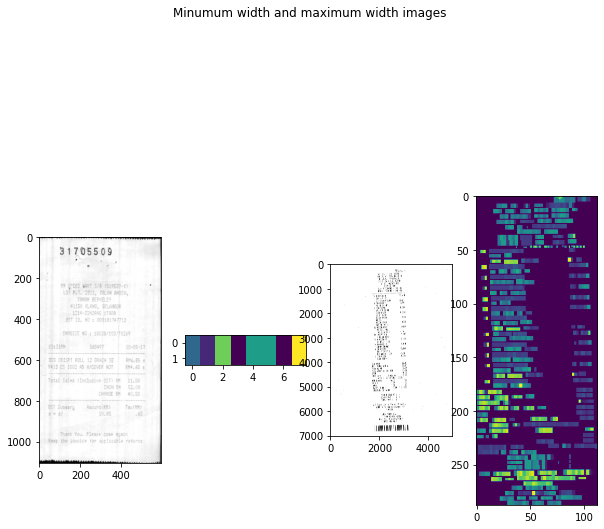

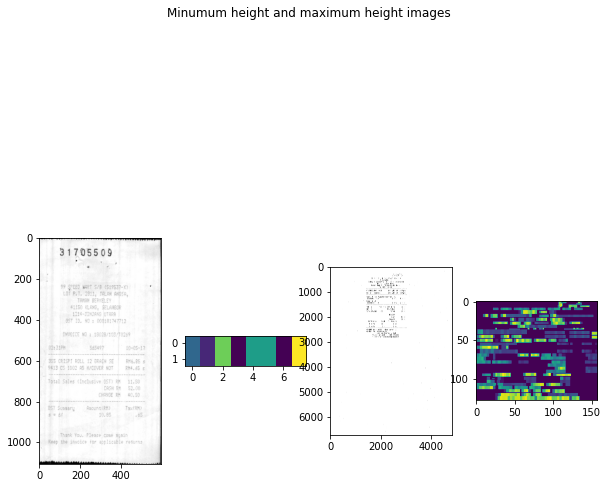

In [1017]:
print_stats_img(tab_img)

prop_nb_class= [6, 5, 3, 31, 573] [0.00970874 0.00809061 0.00485437 0.05016181 0.92718447]
prop_class= [6343182, 81034, 357740, 229554, 106603] [0.89113252 0.0113842  0.0502577  0.03224928 0.0149763 ]


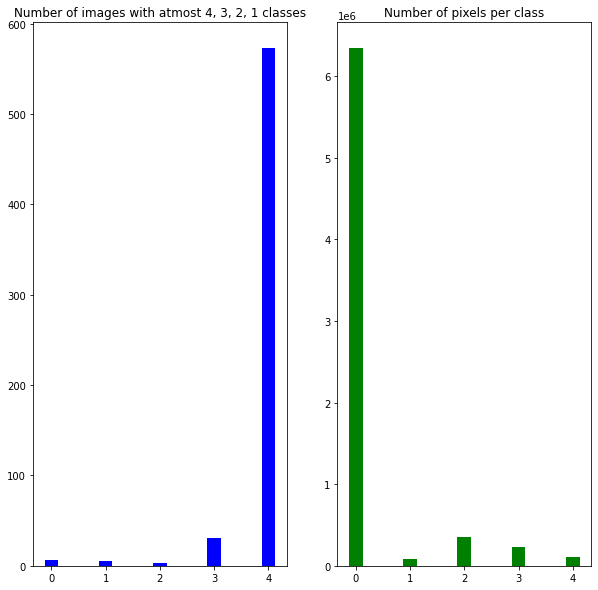

In [1018]:
print_stats_seg(tab_gt)

In [1019]:
def discard_digits_with_low_occurence(tab_img): #unique characters are 93 (ascii)
    nb_unique_digit, count_digit = np.unique(np.concatenate([img.flatten() for img in tab_img]), return_counts=True)
    mask_digit_to_keep = count_digit>nb_digit_threshold #count_digit to count the no of each character appearing in a image
    
    new_digit_nb = np.cumsum(mask_digit_to_keep) #the low occurence less than 10000 are 35
    new_digit_nb -= 1
    
    for i in range(1, len(new_digit_nb)):
        if new_digit_nb[len(new_digit_nb)-i] == new_digit_nb[len(new_digit_nb)-i-1]:
            new_digit_nb[len(new_digit_nb)-i] = target_digit-1
    
    for i in range(0, len(tab_img)):
        for j in range(0, len(nb_unique_digit)):
            tab_img[i][tab_img[i] == nb_unique_digit[j]] = new_digit_nb[j]
    
    return tab_img

In [1020]:
tab_img = discard_digits_with_low_occurence(tab_img)

In [1021]:
filename

'X51007339151.jpg'

In [1025]:
i = index

In [1026]:
list_filenames[i]

'X51007339151.npy'

In [1033]:
print(np.shape(tab_img[i]))
print(np.shape(tab_gt[i]))

(153, 114)
(153, 114)


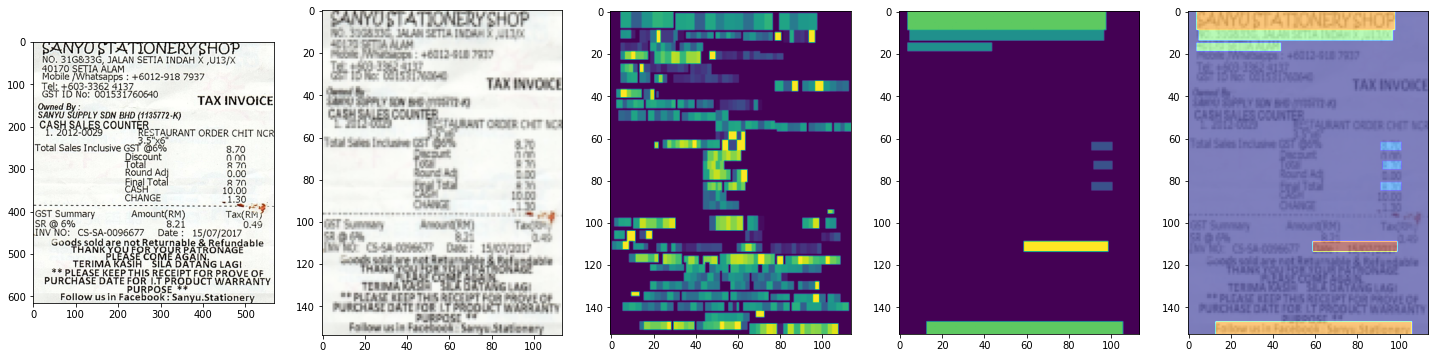

In [1027]:
fig, ax = plt.subplots(1, 5, figsize=(25, 25))
ax[0].imshow(img_cropped)
ax[1].imshow(img_cropped_resized)
ax[2].imshow(tab_img[i])
ax[3].imshow(tab_gt[i])
ax[4].imshow(img_cropped_resized, cmap='gray', alpha=0.5)
ax[4].imshow(tab_gt[i], cmap='jet', alpha=0.5)

In [1029]:
def convert_to_1h(img, gt):
    img_1h = np.eye(target_digit)[img]
    gt_1h = np.eye(target_class)[gt]

    return img_1h, gt_1h

In [1030]:
img_1h, gt_1h = convert_to_1h(tab_img[i], tab_gt[i])

In [1032]:
print(np.shape(img_1h))
print(np.shape(gt_1h))

(153, 114, 61)
(153, 114, 5)


In [1034]:
def resize_to_target(img_1h, gt_1h): #(256,128,61) (256,128,5)
    img_1h = resize(img_1h, (target_height, target_width, target_digit), order=1, anti_aliasing=True)
    gt_1h = resize(gt_1h, (target_height, target_width, target_class), order=1, anti_aliasing=True)
    
    return img_1h, gt_1h

In [1035]:
img_1h, gt_1h = resize_to_target(img_1h, gt_1h)

In [1040]:
input_image_final = resize(img_cropped_resized, (target_height, target_width, img_cropped_resized.shape[2]))

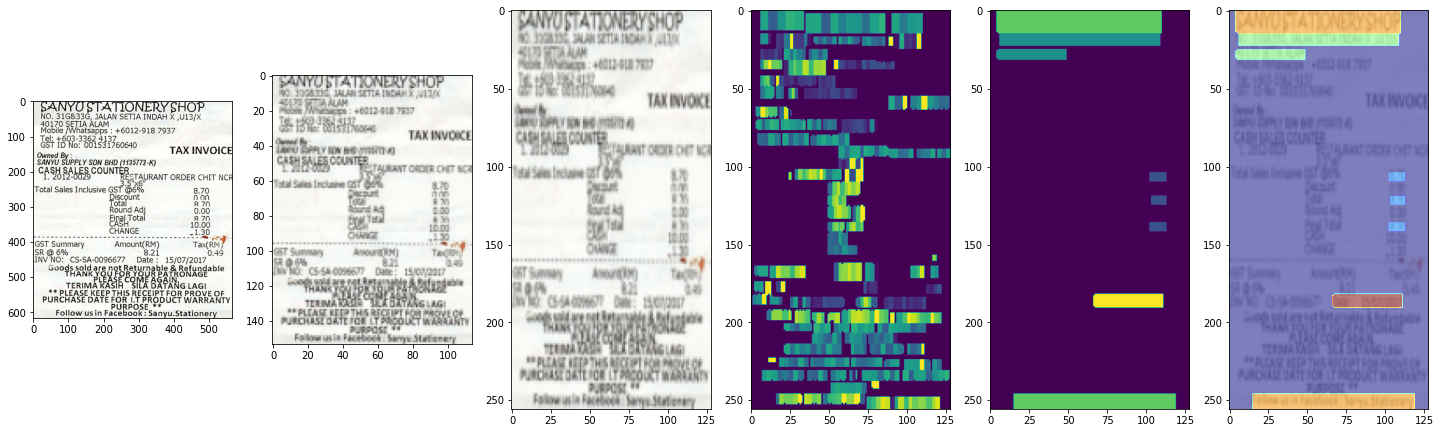

In [1043]:

fig, ax = plt.subplots(1, 6, figsize=(25, 25))
ax[0].imshow(img_cropped)
ax[1].imshow(img_cropped_resized)
ax[2].imshow(input_image_final)
ax[3].imshow(np.apply_along_axis(np.argmax, axis=2, arr=img_1h))
ax[4].imshow(np.apply_along_axis(np.argmax, axis=2, arr=gt_1h))
ax[5].imshow(input_image_final, cmap='gray', alpha=0.5)
ax[5].imshow(np.apply_along_axis(np.argmax, axis=2, arr=gt_1h), cmap='jet', alpha=0.5)

# Class Mapping

- 0 : Other
- 1 : Total 
- 2 : Address 
- 3 : Company name 
- 4 : Date 